### 펫 인프라 시설 데이터 분석

#### 가설
- 만족도가 높은 인프라시설이 많은 지역은 반려동물을 많이 키울것이다.
- 서울시 반려동물 등록건수와 인프라 시설수와의 관계 분석

- 사용 라이브러리 로드

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import mysql.connector
import koreanize_matplotlib 
import json

%matplotlib inline

- 데이터 로드

In [128]:
conn = mysql.connector.connect(
    host = "database-2.c3iym8yog7ht.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "pethub",
    password = "addinedu5",
    database = "pethub"
)

In [129]:
cursor = conn.cursor()
cursor.execute("""
                SELECT l.region, c.type, i.name, r.setiment, i.lat, i.lng
                from review r
                LEFT JOIN pet_infra i ON r.infra_id = i.id
                LEFT JOIN infra_category c ON i.category_id = c.id
                LEFT JOIN region_list l ON i.region_id = l.id;
                """)

result = cursor.fetchall()

infra_reivew_df = pd.DataFrame(result, columns=["region", "type", "name", "setiment", "lat", "lng"])
infra_reivew_df.head()

,region,type,name,setiment,lat,lng
0,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
1,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
2,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
3,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
4,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205


In [130]:
cursor = conn.cursor()
cursor.execute("""
                SELECT l.region, p.breed, r.count
                from region_pet_regist r
                LEFT JOIN region_list l ON r.region_id = l.id
                LEFT JOIN pet_type p ON r.pet_type_id = p.id;
                """)

result = cursor.fetchall()

regist_df = pd.DataFrame(result, columns=["region", "breed", "count"])
regist_df.head()

,region,breed,count
0,종로구,골든 리트리버,156
1,종로구,그레이 하운드,5
2,종로구,달마시안,3
3,종로구,도베르만,21
4,종로구,라브라도 리트리버,136


In [131]:
cursor = conn.cursor()
cursor.execute("""
                SELECT l.region, c.type, p.name, p.lat, p.lng
                from pet_infra p
                LEFT JOIN infra_category c ON p.category_id = c.id
                LEFT JOIN region_list l ON p.region_id = l.id;
                """)

result = cursor.fetchall()

infra_df = pd.DataFrame(result, columns=["region", "type", "name", "lat", "lng"])
infra_df.head()

,region,type,name,lat,lng
0,은평구,공원,은평구 반려견 놀이터,37.490620,126.919205
1,광진구,공원,어린이대공원,37.549362,127.081810
2,마포구,공원,월드컵공원 반려견놀이터,37.563873,126.893501
3,동작구,공원,보라매공원,37.492680,126.919136
4,서초구,공원,매헌시민의숲,37.470684,127.035599


- 지역별 시설 리뷰 수 시각화

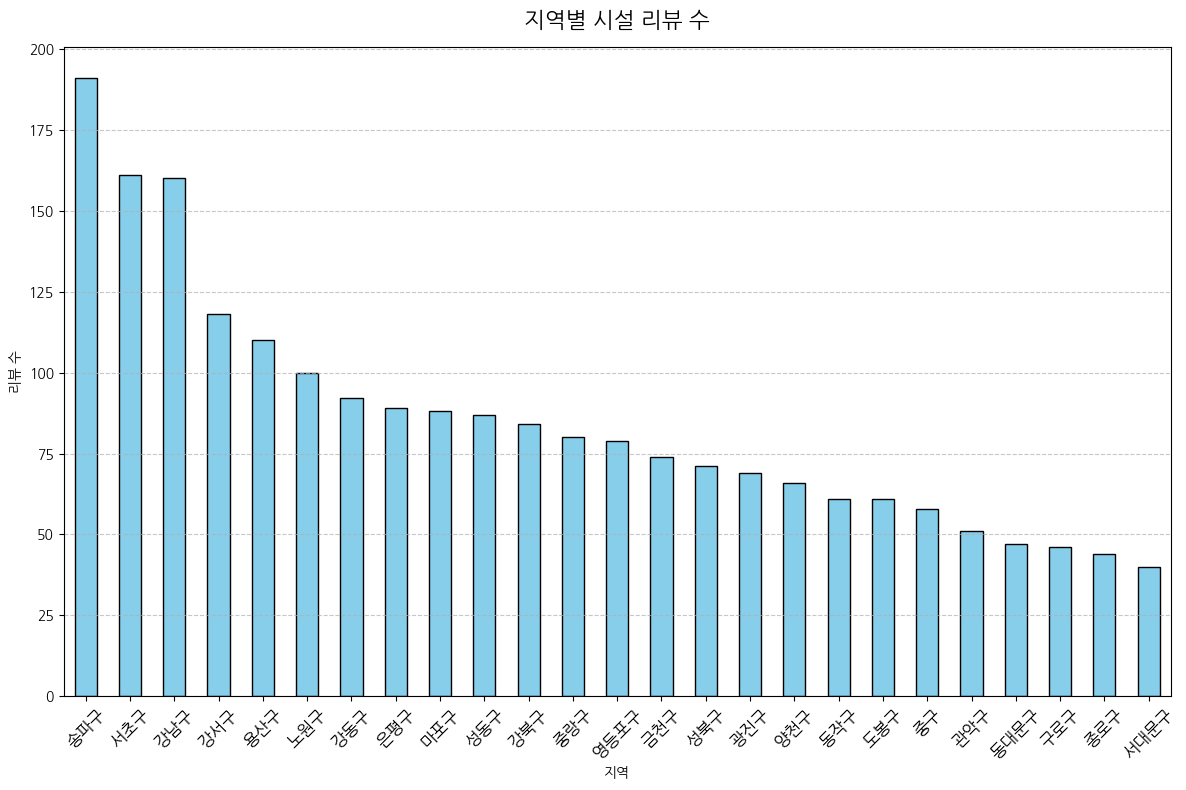

In [132]:
region_review_counts = infra_reivew_df.groupby(["region"])["name"].count().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
region_review_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("지역별 시설 리뷰 수", fontsize=16, pad=15)
plt.xlabel("지역")
plt.ylabel("리뷰 수")
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

- 지역별 시설 긍정, 부정 리뷰 수 시각화

In [133]:
region_sentiment = infra_reivew_df.groupby(["region"])["setiment"].value_counts().unstack(fill_value=0)
region_sentiment = region_sentiment[["Y", "N"]]
region_sentiment.head()

setiment,Y,N
region,,
강남구,121,39
강동구,74,18
강북구,64,20
강서구,88,30
관악구,36,15


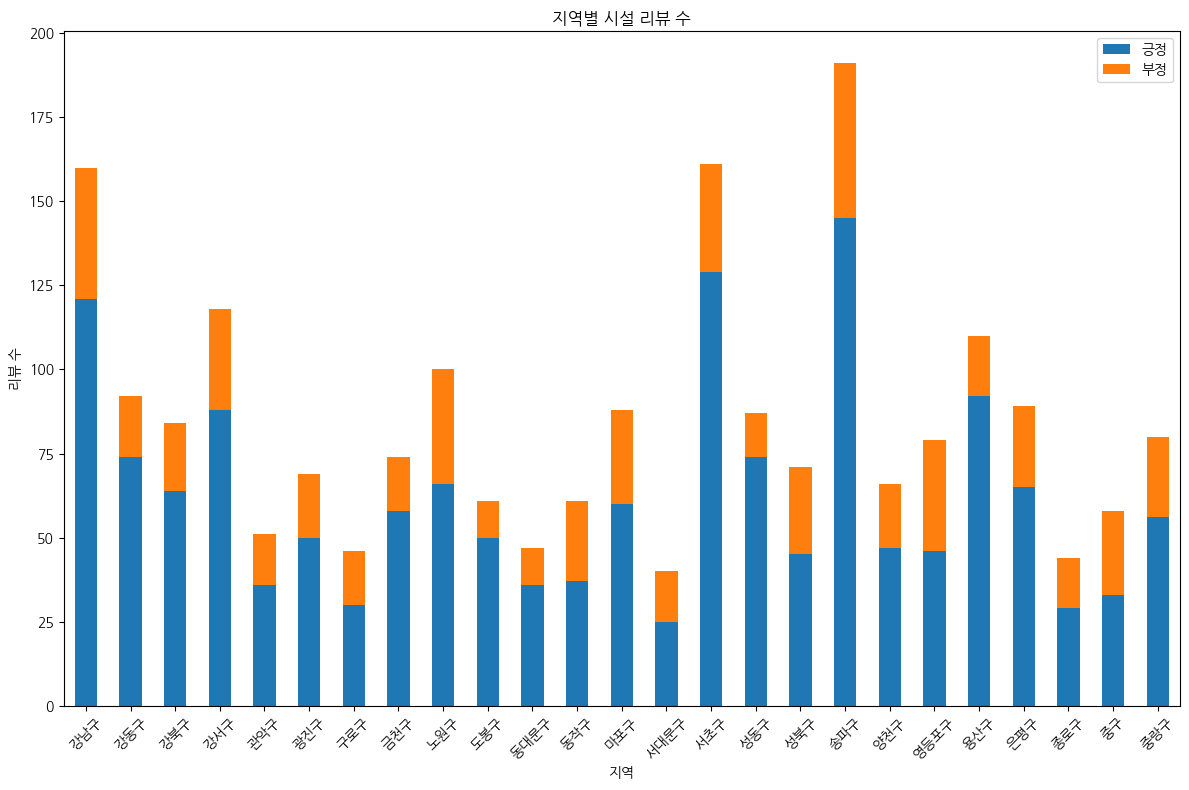

In [134]:
region_sentiment.plot.bar(stacked=True, figsize=(12, 8))

plt.title("지역별 시설 리뷰 수")
plt.xlabel("지역")
plt.ylabel("리뷰 수")
plt.xticks(rotation=45)
plt.legend(["긍정", "부정"])

plt.tight_layout()
plt.show()

- 지역별 시설 부정 리뷰 수 지도 시각화

In [135]:
geo_path = "../data/skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))
geo_str

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': '강동구',
   'properties': {'code': '11250',
    'name': '강동구',
    'name_eng': 'Gangdong-gu',
    'base_year': '2013'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[127.11519584981606, 37.557533180704915],
      [127.16683184366129, 37.57672487388627],
      [127.18408792330152, 37.55814280369575],
      [127.16530984307447, 37.54221851258693],
      [127.14672806823502, 37.51415680680291],
      [127.12123165719615, 37.52528270089],
      [127.1116764203608, 37.540669955324965],
      [127.11519584981606, 37.557533180704915]]]}},
  {'type': 'Feature',
   'id': '송파구',
   'properties': {'code': '11240',
    'name': '송파구',
    'name_eng': 'Songpa-gu',
    'base_year': '2013'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[127.0690698130372, 37.522279423505026],
      [127.10087519791962, 37.524841220167055],
      [127.1116764203608, 37.540669955324965],
      [127.12123165719615, 37.52528270089

In [136]:
positive_infra_reivew_df = infra_reivew_df[infra_reivew_df["setiment"] == "N"]
region_positive_review_data = positive_infra_reivew_df.groupby("region")["setiment"].count().reset_index()
region_positive_review_data.columns = ["region", "negetive_count"]
region_positive_review_data = region_positive_review_data.set_index("region")

map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

choropleth = folium.Choropleth(
    geo_data=geo_str,
    data=region_positive_review_data,
    columns=[region_positive_review_data.index, "negetive_count"],
    key_on="feature.id",
    fill_color="PuRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="지역별 부정 리뷰 수"
).add_to(map)

folium.GeoJson(
    geo_str,
    tooltip=folium.GeoJsonTooltip(
        fields=["name"], 
        aliases=["지역명:"],
        localize=False
    ),
    style_function=lambda x: {
        'fillColor': 'transparent',  # 기존 Choropleth 색상 유지
        'color': 'transparent',  # 경계선 제거
        'weight': 0  # 경계선 두께 제거
    }
).add_to(map)

map

- 지역별 인프라 시설 수 시각화

/tmp/ipykernel_15434/2874875876.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_infra_data, x="region", y="infra_count", palette="coolwarm")


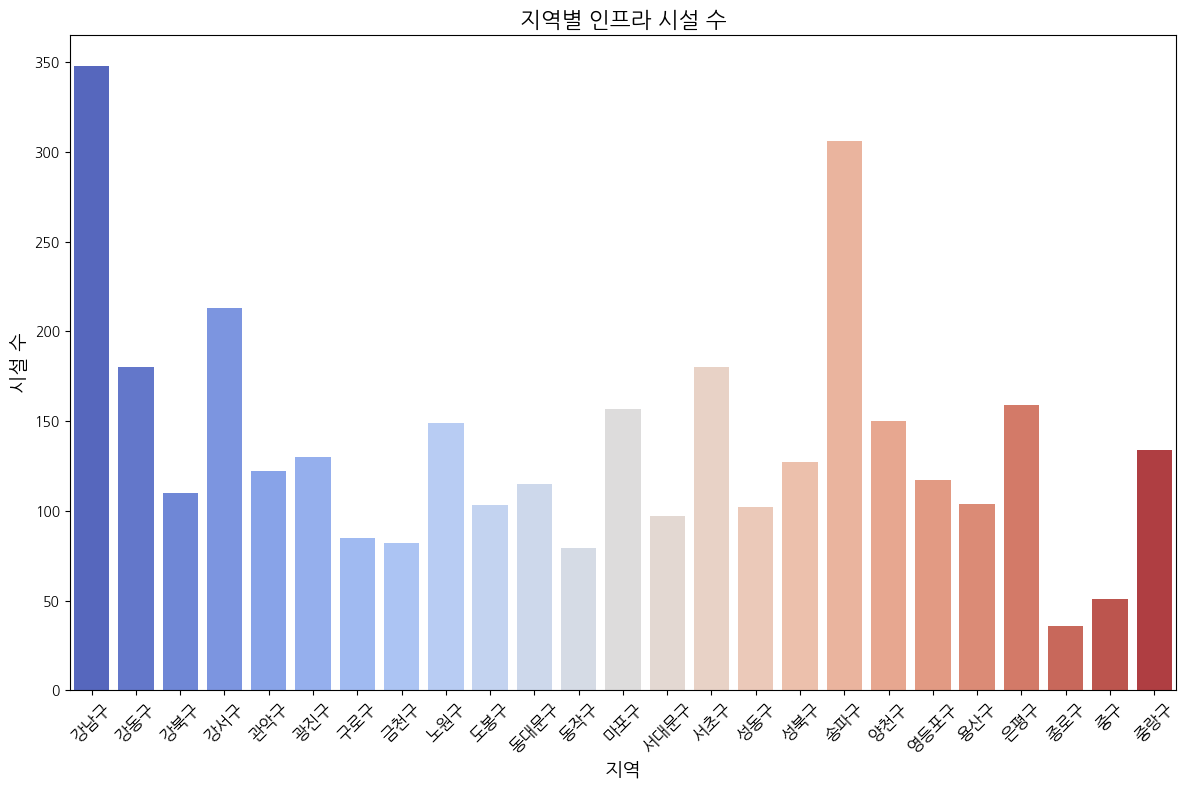

In [137]:
region_infra_data = infra_df.groupby("region")["name"].count().reset_index()
region_infra_data.columns = ["region", "infra_count"]

plt.figure(figsize=(12, 8))
sns.barplot(data=region_infra_data, x="region", y="infra_count", palette="coolwarm")

plt.title("지역별 인프라 시설 수", fontsize=16)
plt.xlabel("지역", fontsize=14)
plt.ylabel("시설 수", fontsize=14)
plt.xticks(rotation=45, fontsize=12)

plt.tight_layout()
plt.show()

In [138]:
region_infra_pivot = region_infra_data.set_index("region")

map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

folium.Choropleth(
    geo_data=geo_str,
    data=region_infra_pivot,
    columns=[region_infra_pivot.index, "infra_count"],
    key_on="feature.id",
    fill_color="PuRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="지역별 인프라 시설 수"
).add_to(map)

folium.GeoJson(
    geo_str,
    tooltip=folium.GeoJsonTooltip(
        fields=["name"], 
        aliases=["지역명:"],
        localize=False
    ),
    style_function=lambda x: {
        'fillColor': 'transparent',  # 기존 Choropleth 색상 유지
        'color': 'transparent',  # 경계선 제거
        'weight': 0  # 경계선 두께 제거
    }
).add_to(map)

map

- 자지구별 등록 현황

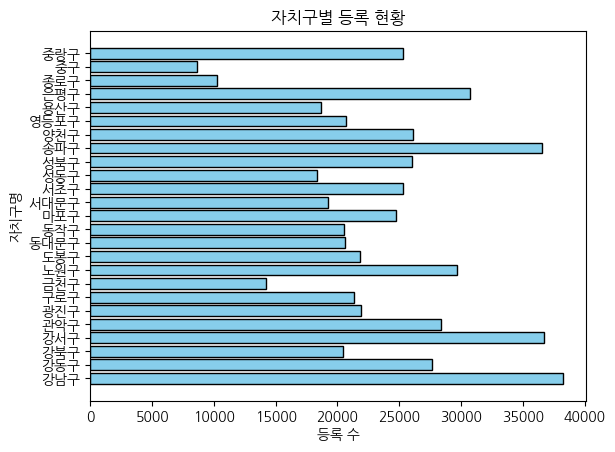

In [139]:
region_regist_data = regist_df.groupby("region")["count"].sum().reset_index()
region_regist_data.columns = ["region", "regist_count"]

plt.Figure(figsize=(12, 8))

plt.barh(region_regist_data["region"], region_regist_data["regist_count"], color="skyblue", edgecolor="black")

plt.title("자치구별 등록 현황")
plt.xlabel("등록 수")
plt.ylabel("자치구명")
plt.show()

In [140]:
region_regist_pivot = region_regist_data.pivot_table(index="region", values="regist_count", aggfunc="sum")

map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

folium.Choropleth(
    geo_data=geo_str,
    data=region_regist_pivot,
    columns=[region_regist_pivot.index, "regist_count"],
    key_on="feature.id",
    fill_color="PuRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="지역별 반려동물 등록 수"
).add_to(map)

folium.GeoJson(
    geo_str,
    tooltip=folium.GeoJsonTooltip(
        fields=["name"], 
        aliases=["지역명:"],
        localize=False
    ),
    style_function=lambda x: {
        'fillColor': 'transparent',  # 기존 Choropleth 색상 유지
        'color': 'transparent',  # 경계선 제거
        'weight': 0  # 경계선 두께 제거
    }
).add_to(map)

map

- 등록 수 와 인프라 시설 수 상관관계

In [141]:
merged_data = pd.concat([region_regist_pivot, region_infra_pivot], axis=1)
merged_data.head()

,regist_count,infra_count
region,,
강남구,38218,348
강동구,27643,180
강북구,20432,110
강서구,36671,213
관악구,28392,122


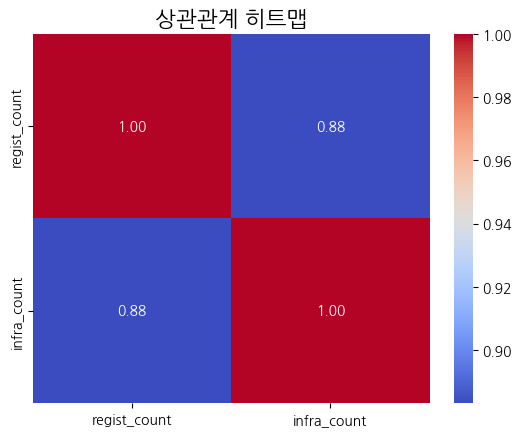

In [142]:
corr =  merged_data[["regist_count", "infra_count"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("상관관계 히트맵", fontsize=16)
plt.show()

#### 결론
-만족도가 높은 인프라시설이 많은 지역은 반려동물을 많이 키울것이다.
    - 반려동물을 가장 많이 키우는 구는 강남구이지만 강남구의 인프라 시설의 경우 만족도가 낮은것으로 확인이됩니다.
    - 따라서 만족도가 높은 인프라시설이 많은 지역은 반려동물을 많이 키우는것은 아니다라는 결론이 나왔습니다.
- 서울시 반려동물 등록건수와 인프라 시설수와의 관계 분석
    - 인프라 시설이 많은 자치구에서 반려동물을 많이 키우고 있는것으로 확인이 됩니다.
    - 또한 인프라 수와 등록 수는 강한 양의 상관관계를 가지고 있습니다.
    - 따라서 인프라 시설이 많을 수록 반려동물을 많이 키우고 있는것으로 확인이 됩니다. 